<a href="https://colab.research.google.com/github/costpetrides/Temperature_Forecasting_MethodComparison/blob/main/ETS%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)


df = pd.read_csv("Athens_meteo.csv",
                 parse_dates=['DAY'],  # change to date time format
                 index_col="DAY")

df = df[['T_mean', 'RH_max', 'RH_mean', 'RH_min', 'P_max','P_mean', 'P_min', 'Rain', 'U', 'U_max']]

df.head()

,T_mean,RH_max,RH_mean,RH_min,P_max,P_mean,P_min,Rain,U,U_max
DAY,,,,,,,,,,
2010-01-01,18.100,61.400,91,33,1003.600,1006.300,1002.000,0.200,4.000,12.700
2010-01-02,15.700,57.400,70,45,1005.200,1008.700,1001.500,0.000,6.800,20.700
2010-01-03,13.600,56.000,76,39,1011.700,1016.700,1008.600,0.000,5.000,15.400
2010-01-04,9.600,50.700,60,38,1021.300,1023.100,1016.800,0.000,4.300,11.000
2010-01-05,13.500,70.500,82,54,1018.700,1022.100,1015.500,0.000,7.900,19.800


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Best ETS Configuration (Grid Search)
Trend          : add
Seasonal       : add
Damped Trend   : False
Seasonal Period: 365
----------------------------------------
MAE            : 1.98 °C
RMSE           : 2.46 °C
R² Score       : 0.877


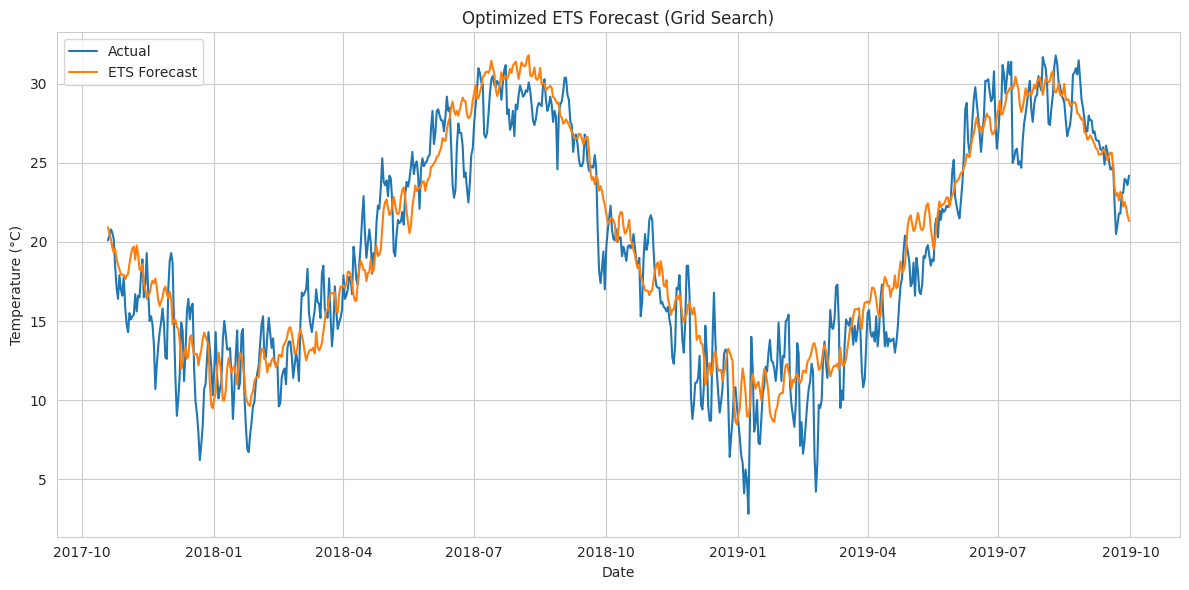


Top 5 ETS Configurations by MAE:
Trend Seasonal  Damped   MAE  RMSE    R2
  add      add   False 1.980 2.465 0.877


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────────────────────────────────────────────
# Step 1: Prepare data (use your already loaded df)
df_ets = df[['T_mean']].dropna().copy()

# Optional: subset to speed up testing (can remove if not needed)
# df_ets = df_ets.loc['2015-01-01':]

# Train/test split (chronological)
split_index = int(len(df_ets) * 0.8)
train = df_ets['T_mean'].iloc[:split_index]
test = df_ets['T_mean'].iloc[split_index:]

# ─────────────────────────────────────────────────────────────
# Step 2: Define hyperparameter grid
trend_options = ['add']
seasonal_options = ['add']
damped_options = [False]
seasonal_period = 365

best_score = float('inf')
best_model = None
best_config = None
results = []

# ─────────────────────────────────────────────────────────────
# Step 3: Grid search over ETS configurations
for trend, seasonal, damped in product(trend_options, seasonal_options, damped_options):
    try:
        model = ExponentialSmoothing(
            train,
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=seasonal_period,
            initialization_method='estimated'
        )
        model_fit = model.fit(optimized=True, use_brute=True)
        forecast = model_fit.forecast(len(test))

        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        r2 = r2_score(test, forecast)

        results.append((trend, seasonal, damped, mae, rmse, r2))

        if mae < best_score:
            best_score = mae
            best_model = model_fit
            best_config = (trend, seasonal, damped)
    except Exception as e:
        continue

# ─────────────────────────────────────────────────────────────
# Step 4: Report best model
trend, seasonal, damped = best_config
forecast = best_model.forecast(len(test))

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print("="*40)
print("Best ETS Configuration (Grid Search)")
print("="*40)
print(f"Trend          : {trend}")
print(f"Seasonal       : {seasonal}")
print(f"Damped Trend   : {damped}")
print(f"Seasonal Period: {seasonal_period}")
print("-" * 40)
print(f"MAE            : {mae:.2f} °C")
print(f"RMSE           : {rmse:.2f} °C")
print(f"R² Score       : {r2:.3f}")
print("="*40)

# ─────────────────────────────────────────────────────────────
# Step 5: Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='ETS Forecast')
plt.title('Optimized ETS Forecast (Grid Search)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# Step 6: Show top configurations by MAE
results_df = pd.DataFrame(results, columns=['Trend', 'Seasonal', 'Damped', 'MAE', 'RMSE', 'R2'])
results_df_sorted = results_df.sort_values(by='MAE')
print("\nTop 5 ETS Configurations by MAE:")
print(results_df_sorted.head(5).to_string(index=False))
